# Sign Language Detection

## Import Libraries

In [1]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 53.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import userdata
import cv2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import mediapipe as mp

## Data Gathering

### Train Dataset

In [ ]:
# Replace KAGGLE_KEY and KAGGLE_USERNAME with your own kaggle key and kaggle username
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d debashishsau/aslamerican-sign-language-aplhabet-dataset

In [ ]:
!unzip "aslamerican-sign-language-aplhabet-dataset"

### Test Dataset

In [ ]:
!kaggle datasets download -d danrasband/asl-alphabet-test

Dataset URL: https://www.kaggle.com/datasets/danrasband/asl-alphabet-test
License(s): CC0-1.0
 21% 5.00M/24.3M [00:00<00:00, 34.7MB/s]
100% 24.3M/24.3M [00:00<00:00, 107MB/s] 


In [ ]:
os.makedirs('asl_alphabet_test', exist_ok=True)
!unzip "asl-alphabet-test" -d "asl_alphabet_test"

Archive:  asl-alphabet-test.zip
  inflating: asl_alphabet_test/A/A0001_test.jpg  
  inflating: asl_alphabet_test/A/A0002_test.jpg  
  inflating: asl_alphabet_test/A/A0003_test.jpg  
  inflating: asl_alphabet_test/A/A0004_test.jpg  
  inflating: asl_alphabet_test/A/A0005_test.jpg  
  inflating: asl_alphabet_test/A/A0006_test.jpg  
  inflating: asl_alphabet_test/A/A0007_test.jpg  
  inflating: asl_alphabet_test/A/A0008_test.jpg  
  inflating: asl_alphabet_test/A/A0009_test.jpg  
  inflating: asl_alphabet_test/A/A0010_test.jpg  
  inflating: asl_alphabet_test/A/A0011_test.jpg  
  inflating: asl_alphabet_test/A/A0012_test.jpg  
  inflating: asl_alphabet_test/A/A0013_test.jpg  
  inflating: asl_alphabet_test/A/A0014_test.jpg  
  inflating: asl_alphabet_test/A/A0015_test.jpg  
  inflating: asl_alphabet_test/A/A0016_test.jpg  
  inflating: asl_alphabet_test/A/A0017_test.jpg  
  inflating: asl_alphabet_test/A/A0018_test.jpg  
  inflating: asl_alphabet_test/A/A0019_test.jpg  
  inflating: asl_a

### Load Dataset

In [ ]:
def load_datasets(train_dir, val_dir=None, img_width=128, img_height=128, batch_size=128):
    """
    Load datasets from the specified directories.

    Args:
        train_dir (str): Path to the training data directory.
        val_dir (str): Path to the validation data directory.
        test_dir (str): Path to the testing data directory.
        img_width (int): Width of the images to be resized to.
        img_height (int): Height of the images to be resized to.
        batch_size (int): Batch size for loading the datasets.

    Returns:
        tuple: train_dataset, validation_dataset, test_dataset
    """
    image_size = (img_width, img_height)
    buffer_size = tf.data.AUTOTUNE

    # Load training dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=image_size,
        interpolation="nearest",
        batch_size=batch_size,
        shuffle=True
    )

    # Load validation dataset
    if (val_dir):
      validation_dataset = tf.keras.utils.image_dataset_from_directory(
          val_dir,
          labels='inferred',
          label_mode='categorical',
          image_size=image_size,
          interpolation="nearest",
          batch_size=batch_size,
          shuffle=False
      )
      validation_dataset = validation_dataset.prefetch(buffer_size=buffer_size)
    else:
      validation_dataset = None

    # Configure datasets for performance
    train_dataset = train_dataset.prefetch(buffer_size=buffer_size)

    return train_dataset, validation_dataset

In [ ]:
train_asl_dir = 'ASL_Alphabet_Dataset/asl_alphabet_train'
train_asl, _ = load_datasets(train_asl_dir)

In [ ]:
test_data_dir = 'asl_alphabet_test'
test, _ = load_datasets(test_data_dir)

## Model Development


In [ ]:
model = tf.keras.models.load_model('resnet50.keras')
# freeze the model layers except the last stage 5th of resnet50 at block3
for layer in model.layers[:-3]:
    layer.trainable = False
    if layer.name.startswith("conv5_block3"):
        layer.trainable = True

# print all layer that trainable is True
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

# Recompile the model with a new optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# custom callback on batch end to clear the memory
import gc
class ClearMemory(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        tf.keras.backend.clear_session()
        gc.collect()

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_asl,
      epochs=1,
      callbacks=[ClearMemory()]
  )
model.save('model_1ep.keras')


872/872 ━━━━━━━━━━━━━━━━━━━━ 4176s 5s/step - accuracy: 0.9017 - loss: 0.3491


In [ ]:
history.history

{'accuracy': [0.9587311744689941], 'loss': [0.13728298246860504]}

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_asl,
      epochs=1,
      callbacks=[ClearMemory()]
  )
model.save('final_model_2ep.keras')

872/872 ━━━━━━━━━━━━━━━━━━━━ 4461s 5s/step - accuracy: 0.9843 - loss: 0.0506


In [ ]:
history.history

{'accuracy': [0.9877887964248657], 'loss': [0.0404808484017849]}

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_asl,
      epochs=1,
      callbacks=[ClearMemory()]
  )
model.save('model_3ep.keras')


872/872 ━━━━━━━━━━━━━━━━━━━━ 4344s 5s/step - accuracy: 0.9912 - loss: 0.0306


In [ ]:
history.history

{'accuracy': [0.9925091862678528], 'loss': [0.026004256680607796]}

## Evaluation

### Simple evaluation

In [ ]:
model.evaluate(test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9727 - loss: 0.1023


[0.10255350917577744, 0.9724137783050537]

### Batched evaluation + Confusion matrix


In [3]:
# Download test data
# link : https://www.kaggle.com/datasets/danrasband/asl-alphabet-test?select=W
!curl -L -o new_test.zip "https://drive.usercontent.google.com/download?id=1i5OI0Or2v9ovjgzuvD4CMu6ig5Vjr0qg&export=download&authuser=0&confirm=t&uuid=f1f5f4ec-ab8c-45b0-b1b5-9ff5cf17686f&at=APvzH3opTN6I42F4Yw0Db5kG5eda:1733750342219"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.3M  100 24.3M    0     0  1674k      0  0:00:14  0:00:14 --:--:-- 6840k


In [4]:
# Download model v4
!curl -L -o modelv4.keras "https://drive.usercontent.google.com/download?id=1p9FkYWcnUGsI71Al2dsaqDtCpXXysktT&export=download&authuser=0&confirm=t&uuid=34a3960c-dbf6-460d-b8b4-886453bdbdc0&at=APvzH3paM2ueGy5XJ9amtc-5PTgz:1733751236392"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  149M  100  149M    0     0  38.9M      0  0:00:03  0:00:03 --:--:-- 38.9M


In [8]:
# Prepare test folder
%%capture
!mkdir test
!unzip new_test.zip -d test

In [5]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

# Initialize MediaPipe Hands once outside the loop for efficiency
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

def crop_hand(image_path, padding=150):
    """Crop the hand region from an image using MediaPipe Hands."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = hands.process(image)
    if not results.multi_hand_landmarks:
        return image  # Return the original image if no hands are detected

    landmarks = results.multi_hand_landmarks[0].landmark
    image_height, image_width, _ = image.shape
    x_min, x_max, y_min, y_max = image_width, 0, image_height, 0

    for landmark in landmarks:
        x, y = landmark.x, landmark.y
        x_pixel, y_pixel = int(x * image_width), int(y * image_height)
        x_min, x_max = min(x_min, x_pixel), max(x_max, x_pixel)
        y_min, y_max = min(y_min, y_pixel), max(y_max, y_pixel)

    x_min = max(0, x_min - padding)
    x_max = min(image_width, x_max + padding)
    y_min = max(0, y_min - padding)
    y_max = min(image_height, y_max + padding)

    return image[y_min:y_max, x_min:x_max]

def preprocess_image(image_path, padding=150):
    """Preprocess image for model input."""
    hand_image = crop_hand(image_path, padding)
    resized_hand_image = cv2.resize(hand_image, (128, 128))
    resized_hand_image = np.expand_dims(resized_hand_image, axis=0)  # Add batch dimension
    return resized_hand_image

def load_data_from_folder(folder_path, padding=150):
    """Load images and labels from folder."""
    images = []
    labels = []

    for label_name in class_names:
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue  # Skip if folder for the label does not exist

        for image_name in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_name)
            if not os.path.isfile(image_path):
                continue

            # Preprocess the image and label
            images.append(preprocess_image(image_path, padding))
            labels.append(class_names.index(label_name))

    images = np.vstack(images)
    labels = np.array(labels)
    return images, labels

def evaluate_model_on_folder(folder_path, model, class_names, padding=150):
    """Evaluate the model on a folder of images."""
    images, true_labels = load_data_from_folder(folder_path, padding)

    # Batch the data for better performance
    batch_size = 32
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

    # Make predictions in batches
    predictions = model.predict(images_tensor, batch_size=batch_size)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy, F1 score, and confusion matrix
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=class_names)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

    return accuracy, f1, cm, report

In [7]:
# Load model
model = tf.keras.models.load_model('modelv4.keras')

In [9]:
results = evaluate_model_on_folder('test', model, class_names, padding=150)

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step
Accuracy: 0.9459770114942528
F1 Score: 0.9457684001079738
Confusion Matrix:
 [[30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1 28  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0 28  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  2  0  0  0 27  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  3 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   1  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0 29  0  0  0  0  0  0  0  

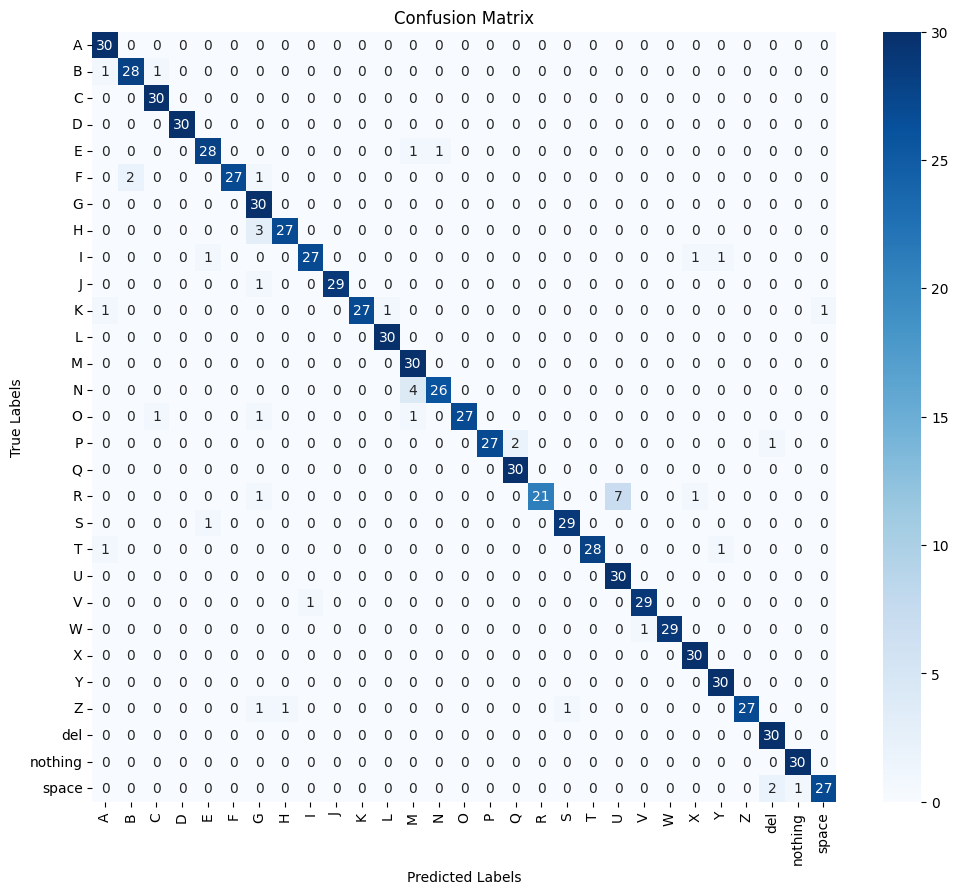

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy, f1, cm, report = results

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Final Implementation


### Inference preperations and functions

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import mediapipe as mp

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

# Initialize MediaPipe Hands once outside the loop for efficiency
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

def load_model(model_path):
    """Load a saved model."""
    return tf.keras.models.load_model(model_path)

def crop_hand(image_path, padding=150):
    """Crop the hand region from an image using MediaPipe Hands."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = hands.process(image)
    if not results.multi_hand_landmarks:
        return image  # Return the original image if no hands are detected

    landmarks = results.multi_hand_landmarks[0].landmark
    image_height, image_width, _ = image.shape
    x_min, x_max, y_min, y_max = image_width, 0, image_height, 0

    for landmark in landmarks:
        x, y = landmark.x, landmark.y
        x_pixel, y_pixel = int(x * image_width), int(y * image_height)
        x_min, x_max = min(x_min, x_pixel), max(x_max, x_pixel)
        y_min, y_max = min(y_min, y_pixel), max(y_max, y_pixel)

    x_min = max(0, x_min - padding)
    x_max = min(image_width, x_max + padding)
    y_min = max(0, y_min - padding)
    y_max = min(image_height, y_max + padding)

    return image[y_min:y_max, x_min:x_max]

def preprocess_image(image_path, padding=150):
    """Preprocess image for model input."""
    hand_image = crop_hand(image_path, padding)
    resized_hand_image = cv2.resize(hand_image, (128, 128))
    resized_hand_image = np.expand_dims(resized_hand_image, axis=0) # Add batch dimension
    return resized_hand_image

def load_image(image_path, padding=150):
    """Load images and labels from folder."""
    images = []
    images.append(preprocess_image(image_path, padding))
    images = np.vstack(images)
    return images

def predict_image(image_path, model, class_names, padding=150):
    """Inference on a single image."""
    images = load_image(image_path, padding)

    # Batch the data for better performance
    batch_size = 1
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

    # Make predictions in batches
    predictions = model.predict(images_tensor, batch_size=batch_size)
    predicted_labels = np.argmax(predictions, axis=1)

    return class_names[predicted_labels[0]]

### Download and Load Model


In [ ]:
# Download model v4
!curl -L -o modelv4.keras "https://drive.usercontent.google.com/download?id=1p9FkYWcnUGsI71Al2dsaqDtCpXXysktT&export=download&authuser=0&confirm=t&uuid=34a3960c-dbf6-460d-b8b4-886453bdbdc0&at=APvzH3paM2ueGy5XJ9amtc-5PTgz:1733751236392"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  149M  100  149M    0     0  39.0M      0  0:00:03  0:00:03 --:--:-- 39.0M


In [ ]:
# Load model
model = load_model('modelv4.keras')

### Predict single image

In [ ]:
# For inference, just provide the images
image_path = 'space29.jpg' # Change the image path if needed
pred = predict_image(image_path, model, class_names, padding=150)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


'space'